# Exploratory Data Analysis

### **NOTE**
Please create a folder named "datasets" in Google Drive and upload the unzipped review dataset into that folder, then run the following code.

## Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Generally, there's supposed to be some obvious disadvantage of the product if the score falls under 4, 
# so it's considered to be negative even if the score is 3.
df['Sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


## Preprocess the data

### Deduplicate the review set

After taking a careful look at the dataset it can be found out
that there are many duplicate reviews in the dataset. It seems that
when a product with one particular flavour etc. is commented, then this comment will be copied to the same products with different flavours.

In [ ]:
# Show some duplicate reviews
index_duplicate = df.duplicated(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep=False)
duplicate_terms = df.loc[index_duplicate].sort_values('UserId', ascending=True)
display(duplicate_terms.head(10))

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
180871,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,negative
83317,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,negative
290947,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",positive
496893,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",positive
455533,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",positive
181210,181211,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...,negative
83656,83657,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...,negative
455359,455360,B005HG9ERW,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,positive
290773,290774,B005HG9ESG,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,positive
496719,496720,B005HG9ET0,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,positive


In [ ]:
# Deduplicate the review set
df = df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep='first')

### Preprocess the texts

In [ ]:
# Remove all components belonging to HTML files and stop words
import nltk
nltk.download('stopwords')
# # nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

stop_words = stopwords.words('english')
contents = []
for text in df['Text']:

  # remove HTML components
  content = BeautifulSoup(text).get_text()

  # remove non-alphabetic characters
  content = re.sub(r'[^a-zA-Z]', ' ', content)

  # remove stop words
  content = content.split()  # # content = nltk.word_tokenize(content)
  content = [word for word in content if word not in stop_words]
  content = ' '.join(content)

  contents.append(content)
df['P_Text'] = contents

preprocessed_text = ' '.join(df['P_Text'].values)

print(type(preprocessed_text))
print(type(stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<class 'str'>
<class 'list'>


## Explore the data

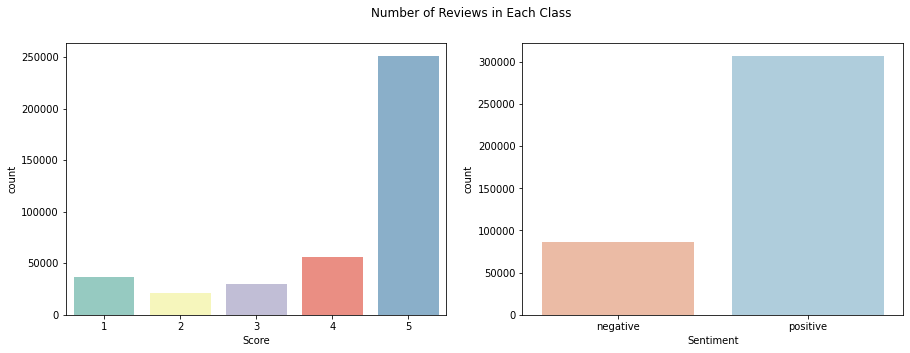

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Number of Reviews in Each Class')

# Count the reviews of each score
sns.countplot(x='Score', data=df, palette='Set3', ax=axs[0])
plt.xlabel('Score')

# Count the positive and the negative reviews
sns.countplot(x='Sentiment', order=['negative', 'positive'], data=df, palette='RdBu', ax=axs[1])
plt.xlabel('Sentiment')
plt.show()

# Separate the reviews into two groups according to their polarities
df_pos = df.loc[df['Sentiment'] == 'positive']
df_neg = df.loc[df['Sentiment'] == 'negative']
prep_text_pos = ' '.join(df_pos['P_Text'].values)
prep_text_neg = ' '.join(df_neg['P_Text'].values)

According to the count plots there are obviously more positive reviews than negative reviews.

In [ ]:
# Draw wordclouds of all texts, of positive and of negative texts
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, stop_words=STOPWORDS, axes=None, title=''):
  wcloud = WordCloud(
      background_color='black',
      stopwords=stop_words,
      max_words=100,
      max_font_size=50,
      width=300,
      height=150
  ).generate(text)
  if axes is None:
    axes = plt.subplot()
  axes.imshow(wcloud)
  axes.set_title(title)
  axes.axis('off')

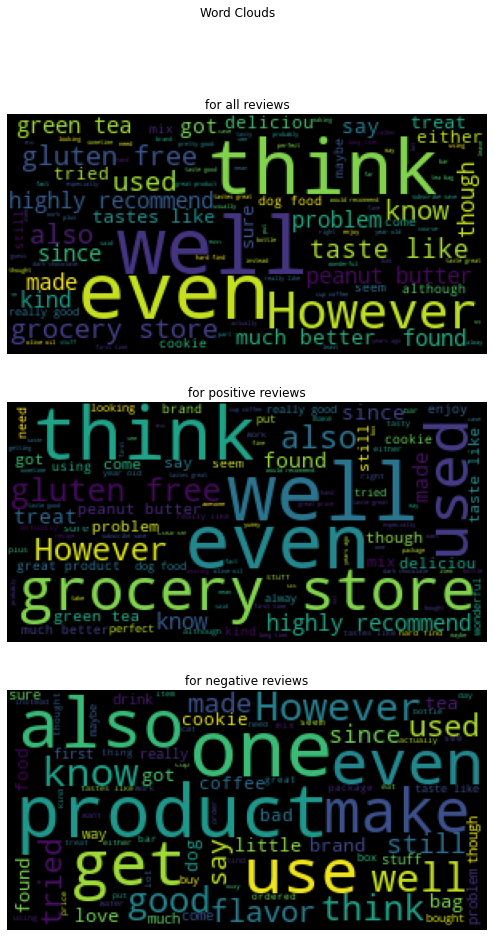

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Word Clouds')
plot_wordcloud(preprocessed_text, stop_words, axs[0], 'for all reviews')
plot_wordcloud(prep_text_pos, stop_words, axs[1], 'for positive reviews')
plot_wordcloud(prep_text_neg, stop_words, axs[2], 'for negative reviews')
plt.show()

From the above word clouds it can be concluded that the words "however", "even", "well", "think" etc. are widely used in both positive and negative reviews. Words or phrases like "grocery store", "gluten free", and "peanut butter" appear more frequently in positive reviews, while "one", "product", "flavor", "tried", "make", "get", "also" and "know" are more related with negative reviews.

In [12]:
# Count the number of words in each text
df['num_words'] = df['P_Text'].apply(lambda x: len(str(x).split()))
avr_num_words = np.mean(df['num_words'])
print(avr_num_words)

45.24838487763147


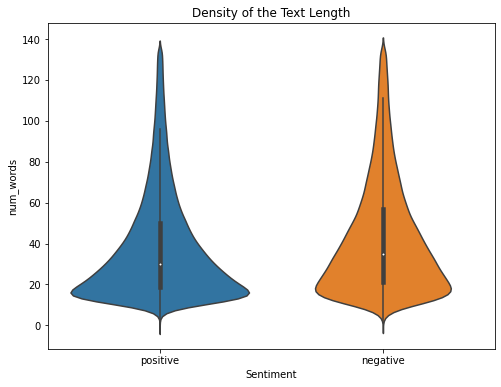

In [13]:
# Estimate the distribution of the texts of either polarity 
# with respect to the length of a text
fig = plt.figure(figsize=(8, 6))
sns.violinplot(
    x='Sentiment',
    y='num_words',
    data=df.loc[df['num_words'] < avr_num_words * 3]
)
plt.title('Density of the Text Length')
plt.show()

It can be read from the violin plot that both the positive and the negative reviews mainly have a length of about 30 words, and that the negative reviews are generally a little longer than positive reviews.

In [14]:
# # drive.flush_and_unmount() # unmount Google Drive